In [19]:
import pandas as pd
from matplotlib import pyplot

DATA = 'tests/ff_server.csv'

data = pd.read_csv(DATA, header=0)


In [20]:
data.head()

,group,split_size,n_threads,compression_time,decompression_time,diff
0,small,1000,2,0.363979,0.149401,OK
1,big,1000,2,3.857443,1.744561,OK
2,some_large,1000,2,63.832716,26.886519,OK
3,some_small,1000,2,7.187255,2.973841,OK
4,huge,1000,2,46.682576,19.321278,OK


<Axes: >

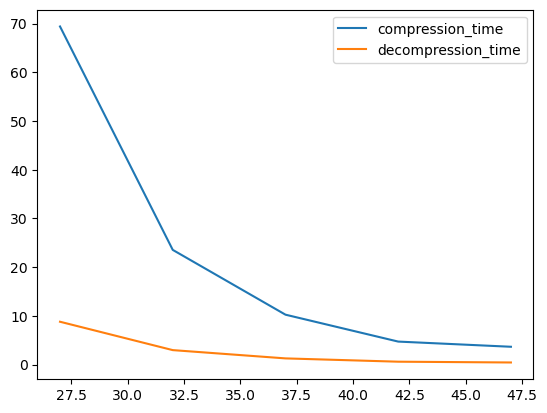

In [32]:
# No errors
assert (data['diff'] == 'OK').all()

data.groupby(['group', 'split_size'])[['compression_time', 'decompression_time']].get_group(('some_large', 1000000)).plot()